<a href="https://colab.research.google.com/github/ValentinoMalakianno/PCVK_2023/blob/main/UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TI 3G - UAS PCVK**

**KELOMPOK 2**

Farhan Ramazain

Ilham Khalis

Muhammad Bagas

Valentino Malakianno

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import zipfile
import re
import cv2
import random
import os
from PIL import Image
import subprocess
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Image Pre-processing**

In [3]:
directory = '/content/drive/MyDrive/Kelompok 2'
image_files = [file for file in os.listdir(directory) if file.endswith((".jpg"))]

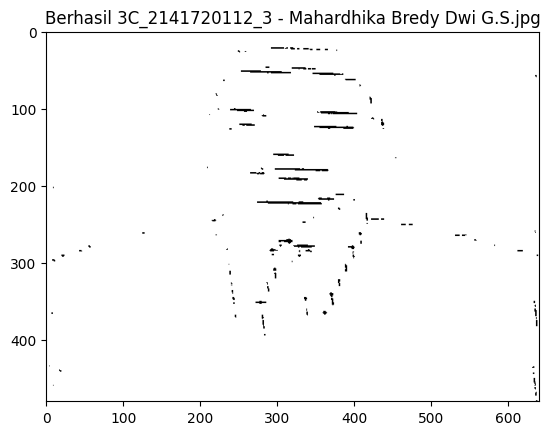

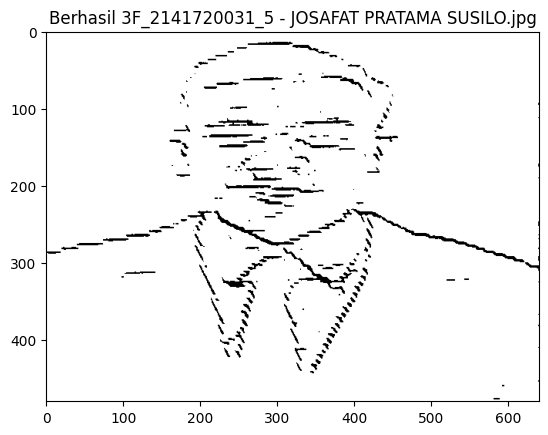

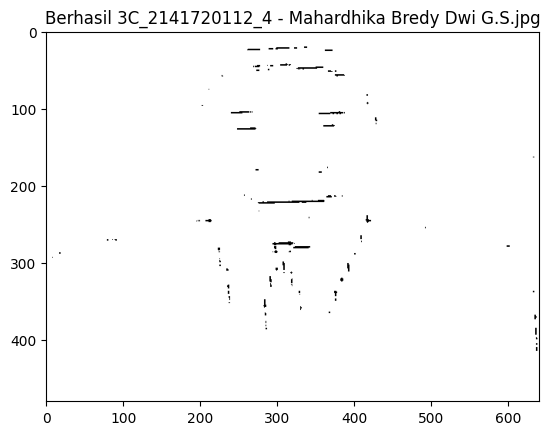

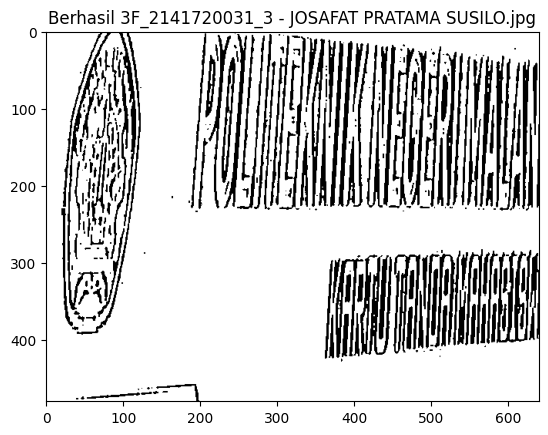

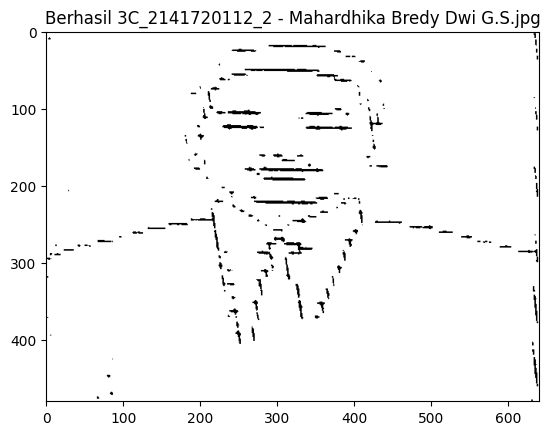

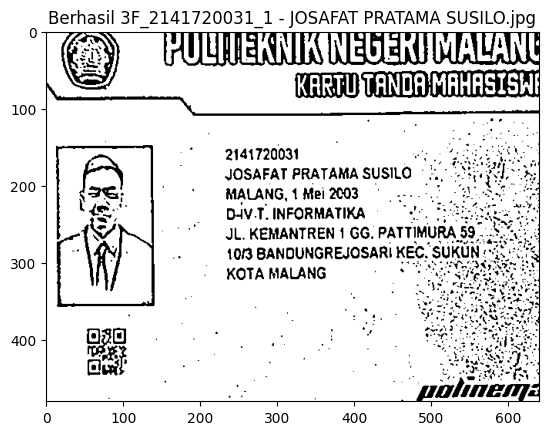

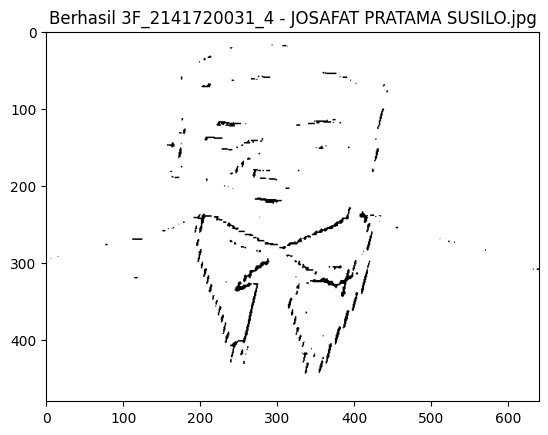

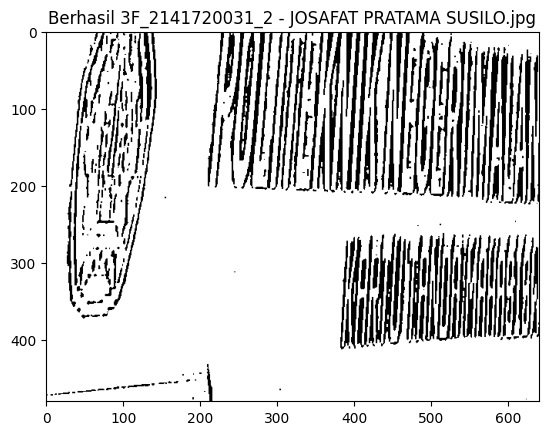

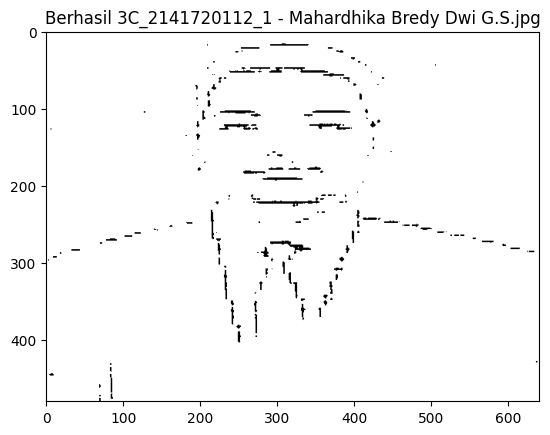

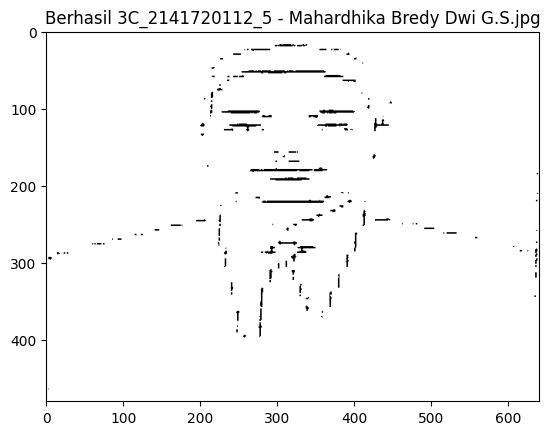

In [4]:
successful_images = []

for image_file in image_files:
  image_path = os.path.join(directory, image_file)
  def nothing(x):
    pass

  def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
      area = cv2.contourArea(i)
      if area > 5000:
        peri = cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
          biggest = approx
          max_area = area
    return biggest, max_area

  def drawRectangle(img,biggest,thickness):
      cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)

  def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

  widthImg = 640
  heightImg = 480
  img = cv2.imread(image_path)
  img = cv2.resize(img,(widthImg, heightImg))
  imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)

  median = np.median(imgBlur)

  # Set lower and upper thresholds based on the median value
  lower_threshold = int(max(0, 0.7 * median))
  upper_threshold = int(min(255, 1.3 * median))
  imgThreshold = cv2.Canny(imgBlur, lower_threshold, upper_threshold)
  kernel = np.ones((5,5))
  imgDilation = cv2.dilate(imgThreshold, kernel, iterations=2)
  imgThreshold = cv2.erode(imgDilation, kernel, iterations=1)
  imgContours = img.copy()
  imgBigContour = img.copy()
  contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(imgContours, contours, -1, (0,255,0), 10)

  biggest, maxArea = biggestContour(contours)
  if biggest.size != 0:
    biggest = reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0,255,0), 20)
    imgBigContour = drawRectangle(imgBigContour, biggest, 2)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    # kurangi 20pixel setiap sisi
    imgWarpColored = imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]
    imgWarpColored = cv2.resize(imgWarpColored, (widthImg, heightImg))
    #adaptive threshold
    imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
    imgAdaptiveThre = cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2)
    imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
    imgAdaptiveThre = cv2.medianBlur(imgAdaptiveThre,3)

    successful_images.append(imgAdaptiveThre)

    plt.figure()
    imgAdaptiveThre_rgb = cv2.cvtColor(imgAdaptiveThre, cv2.COLOR_GRAY2RGB)
    plt.imshow(imgAdaptiveThre_rgb)
    plt.title('Berhasil '+image_file)

  else:
    plt.figure()
    imgContours_rgb = cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB)
    plt.imshow(imgContours_rgb)
    plt.title(image_file)
plt.show()